In [5]:
from utils import datasets, kl_cpd, models, metrics
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
experiments_name = 'explosion'
train_dataset, test_dataset = datasets.CPDDatasets(experiments_name=experiments_name).get_dataset_()

Equal sampling is impossible, do random sampling.


In [7]:
args = {}
args['wnd_dim'] = 4
args['RNN_hid_dim'] = 16
args['batch_size'] = 8
args['lr'] = 1e-4
args['weight_decay'] = 0.
args['grad_clip'] = 10
args['CRITIC_ITERS'] = 5
args['weight_clip'] = .1
args['lambda_ae'] = 0.1 #0.001
args['lambda_real'] = 10 #0.1
args['num_layers'] = 1
args['data_dim'] = 12288
args['emb_dim'] = 100

args['window_1'] = 4
args['window_2'] = 4

args['sqdist'] = 50

In [8]:
for name in ['x3d_m']:
    extractor = torch.hub.load('facebookresearch/pytorchvideo:main', name, pretrained=True)
    extractor = nn.Sequential(*list(extractor.blocks[:5]))
    
    seed = 0
    models.fix_seeds(seed)
    experiments_name = ('explosion')

    netG = models.NetG(args)
    netD = models.NetD(args)

    kl_cpd_model = models.KLCPDVideo(netG, netD, args, train_dataset=train_dataset, test_dataset=test_dataset, 
                                     extractor=extractor)
    
    logger = TensorBoardLogger(save_dir='logs/explosion', name='kl_cpd')
    
    early_stop_callback = EarlyStopping(monitor="val_mmd2_real_D", stopping_threshold=1e-5, 
                                        verbose=True, mode="min", patience=5)

    for param in kl_cpd_model.extractor.parameters():
        param.requires_grad = False

    trainer = pl.Trainer(
        max_epochs=1,
        gpus='1',
        benchmark=True,
        check_val_every_n_epoch=1,
        gradient_clip_val=args['grad_clip'],
        logger=logger,
        callbacks=early_stop_callback
    )

    trainer.fit(kl_cpd_model)
    torch.save(kl_cpd_model.state_dict(), 'model_' + name + '.pth')    
    
    threshold_number = 5
    threshold_list = np.linspace(-5, 5, threshold_number)
    threshold_list = 1 / (1 + np.exp(-threshold_list))
    threshold_list = [-0.001] + list(threshold_list) + [1.001]
    
    
    _, delay_list, fp_delay_list = metrics.evaluation_pipeline(kl_cpd_model, 
                                                           kl_cpd_model.val_dataloader(),  
                                                           threshold_list, 
                                                           device='cuda', 
                                                           model_type='klcpd',
                                                           verbose=False)    


    path_to_saves = ''
    metrics.write_metrics_to_file(path_to_saves + 'result_metrics.txt', _, name)    
    
    plt.figure(figsize=(12, 12))
    plt.plot(fp_delay_list.values(), delay_list.values(), '-o', markersize=8, label='TSCP')
    plt.xlabel('Mean Time to False Alarm', fontsize=28)
    plt.ylabel('Mean Detection Delay', fontsize=28)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(loc='upper left', fontsize=26);        
    plt.savefig('saves/figure_' + str(name) + '.png', dpi=300)

Using cache found in /home/eromanenkova/.cache/torch/hub/facebookresearch_pytorchvideo_main
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type       | Params
-----------------------------------------
0 | netG      | NetG       | 1.4 M 
1 | netD      | NetD       | 2.5 M 
2 | extractor | Sequential | 2.0 M 
-----------------------------------------
4.0 M     Trainable params
2.0 M     Non-trainable params
6.0 M     Total params
23.865    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc167c66700>
Traceback (most recent call last):
  File "/home/eromanenkova/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/eromanenkova/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/eromanenkova/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc167c66700><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc167c66700>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/eromanenkova/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", lin

torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])
torch.Size([8, 192, 4, 8, 8])



  0%|                                                                                             | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt



In [5]:
batch = next(iter(kl_cpd_model.val_dataloader()))

In [40]:
def get_klcpd_output(kl_cpd_model, batch, window):
    batch = batch.to(kl_cpd_model.device)
    if len(batch.shape) <= 4:
        seq_len = batch.shape[1]
    else:
        seq_len = batch.shape[2]

    batch_history_slices, batch_future_slices = kl_cpd._history_future_separation_test(batch, window)
    sigma_var = kl_cpd_model.sigma_var.to(kl_cpd_model.device)

    pred_out = []
    for i in range(len(batch_history_slices)):
        zeros = torch.zeros(1, seq_len)

        curr_history = kl_cpd_model.extractor(batch_history_slices[i]).transpose(1, 2).flatten(2)
        curr_history, _ = kl_cpd_model.netD(curr_history.to(torch.float32))

        curr_future = kl_cpd_model.extractor(batch_future_slices[i]).transpose(1, 2).flatten(2)
        curr_future, _ = kl_cpd_model.netD(curr_future.to(torch.float32))

        curr_history, curr_future = [Xi.reshape(*Xi.shape[:2], -1) for Xi in [curr_history, curr_future]]
        mmd_scores = kl_cpd.batch_mmd2_loss(curr_history, curr_future, sigma_var)
        zeros[:, 2 * window - 1:] = mmd_scores
        pred_out.append(zeros)
    pred_out = torch.cat(pred_out).to(kl_cpd_model.device)
    po = pred_out
    print(torch.tanh(po/torch.norm(po, p=3, dim=1, keepdim=True)))
    print(torch.softmax(po/torch.max(po, dim=1, keepdim=True), dim=1))
    # breakpoint()
    #pred_out = pred_out / pred_out.max(1).values.expand(pred_out.shape[1], pred_out.shape[0]).transpose(0, 1)
    #TODO check
    #pred_out = torch.tanh(pred_out * 10 ** 7)
    return pred_out

In [41]:
# %%debug
pred_out = get_klcpd_output(kl_cpd_model, batch[0], 4)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1168, 0.0134,
         0.0469, 0.7613, 0.0122, 0.0354, 0.0066, 0.0180, 0.0437],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0510, 0.0031,
         0.0136, 0.0145, 0.7527, 0.0958, 0.0050, 0.2109, 0.3539],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1025, 0.4029,
         0.4261, 0.0166, 0.1214, 0.0133, 0.1087, 0.3764, 0.7227],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0836, 0.3602,
         0.2545, 0.0018, 0.0174, 0.6602, 0.6360, 0.0472, 0.1659],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2511, 0.1890,
         0.0746, 0.6395, 0.2818, 0.0209, 0.0107, 0.6199, 0.4734],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5545, 0.0219,
         0.2002, 0.0184, 0.5053, 0.5801, 0.3525, 0.3110, 0.5271],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0146, 0.0016,
         0.0862, 0.7614, 0.0599, 0.01

TypeError: unsupported operand type(s) for /: 'Tensor' and 'torch.return_types.max'

In [12]:
labels = batch[1]

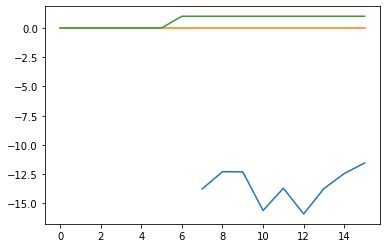

In [37]:
i = 2
#plt.plot(pred_out[i].detach().cpu().numpy())
#plt.plot(torch.tanh(pred_out[i] * 10 ** 5).detach().cpu().numpy())
plt.plot(torch.log(pred_out[i]).detach().cpu().numpy())
plt.plot((1 / (1 - 1 / pred_out[i])).detach().cpu().numpy())

plt.plot(labels[i].detach().cpu().numpy())

In [76]:
pred_out.max(1).values

tensor([4.7610e-06, 1.8587e-06, 3.3578e-06, 3.4813e-06, 1.6716e-06, 1.8619e-06,
        3.7566e-06, 1.7263e-06], grad_fn=<MaxBackward0>)

tensor([[4.7610e-06, 4.7610e-06, 4.7610e-06, 4.7610e-06, 4.7610e-06, 4.7610e-06,
         4.7610e-06, 4.7610e-06, 4.7610e-06, 4.7610e-06, 4.7610e-06, 4.7610e-06,
         4.7610e-06, 4.7610e-06, 4.7610e-06, 4.7610e-06],
        [1.8587e-06, 1.8587e-06, 1.8587e-06, 1.8587e-06, 1.8587e-06, 1.8587e-06,
         1.8587e-06, 1.8587e-06, 1.8587e-06, 1.8587e-06, 1.8587e-06, 1.8587e-06,
         1.8587e-06, 1.8587e-06, 1.8587e-06, 1.8587e-06],
        [3.3578e-06, 3.3578e-06, 3.3578e-06, 3.3578e-06, 3.3578e-06, 3.3578e-06,
         3.3578e-06, 3.3578e-06, 3.3578e-06, 3.3578e-06, 3.3578e-06, 3.3578e-06,
         3.3578e-06, 3.3578e-06, 3.3578e-06, 3.3578e-06],
        [3.4813e-06, 3.4813e-06, 3.4813e-06, 3.4813e-06, 3.4813e-06, 3.4813e-06,
         3.4813e-06, 3.4813e-06, 3.4813e-06, 3.4813e-06, 3.4813e-06, 3.4813e-06,
         3.4813e-06, 3.4813e-06, 3.4813e-06, 3.4813e-06],
        [1.6716e-06, 1.6716e-06, 1.6716e-06, 1.6716e-06, 1.6716e-06, 1.6716e-06,
         1.6716e-06, 1.6716e-06, 1.6716